<a href="https://colab.research.google.com/github/Ohm-T/Unsupervised-Classification/blob/main/Project_2_Analysis_of_handwritten_signatures_for_identity_verification_identity_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# <font color='ForestGreen'> PROJET 2 </font>
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

---
## <font color='LimeGreen'>1.   Data vizualisation 🌍 </font>

In [3]:
# Importer fichier dans gg colab
file_4G = 'Complexité avec 4G (100x25).txt'
file_8G = 'Complexité avec 8G (100x25).txt'
file_24G = 'Complexité avec 24G (100x25).txt'
signatures = ['Signature {}'.format(i) for i in range(1,26)]

# Données de complexité
complex_4G = pd.read_table(file_4G, header=None)
complex_8G = pd.read_table(file_8G, header=None)
complex_24G = pd.read_table(file_24G, header=None)

complex_4G.columns = signatures
complex_8G.columns = signatures
complex_24G.columns = signatures

# Réglé : pb de str avec , => to float avec .
for i in complex_4G.columns:
  complex_4G[i] = complex_4G[i].str.replace(',', '.').astype(float)
  complex_8G[i] = complex_8G[i].str.replace(',', '.').astype(float)
  complex_24G[i] = complex_24G[i].str.replace(',', '.').astype(float)





AttributeError: ignored

In [ ]:
complex_24G.head()

,Signature 1,Signature 2,Signature 3,Signature 4,Signature 5,Signature 6,Signature 7,Signature 8,Signature 9,Signature 10,Signature 11,Signature 12,Signature 13,Signature 14,Signature 15,Signature 16,Signature 17,Signature 18,Signature 19,Signature 20,Signature 21,Signature 22,Signature 23,Signature 24,Signature 25
0,19.418379,21.168041,17.978114,20.349810,18.958750,17.880597,20.276367,23.207289,19.794416,19.319806,19.040742,19.107257,19.372960,20.761771,20.443187,18.574054,17.278135,19.541206,17.414797,20.118963,17.522062,20.535226,17.915963,19.754014,17.689681
1,23.891532,21.410094,22.217169,19.488479,21.591756,25.032245,23.598878,24.555337,22.085059,25.036497,22.762188,22.807787,24.656660,23.006744,21.215481,22.905254,23.247706,22.164662,21.523057,21.123666,21.441618,23.195070,20.844714,23.126296,21.378493
2,26.781532,27.125942,26.783903,26.252523,26.571913,27.578733,26.430292,26.166015,26.725454,26.996119,26.310383,26.986084,25.352634,26.419390,26.850359,26.402912,27.805016,27.250634,27.027102,27.148904,26.513630,26.352621,26.475316,26.158157,25.317402
3,25.570153,23.337583,26.074787,23.298449,23.013962,25.097759,23.964793,26.672919,26.146179,25.818987,25.940086,25.081272,26.095806,26.244383,25.381787,25.172487,26.135858,25.322893,25.230605,25.515222,24.485672,26.171534,25.472147,26.057215,25.046337
4,19.803114,22.290674,22.967518,21.656370,21.557347,24.588345,24.913413,25.045552,22.836658,23.619319,23.675137,21.064089,23.161481,23.183328,24.490852,22.865086,22.900575,22.795431,23.715837,24.535791,22.223535,24.457346,23.373926,24.337768,23.433979


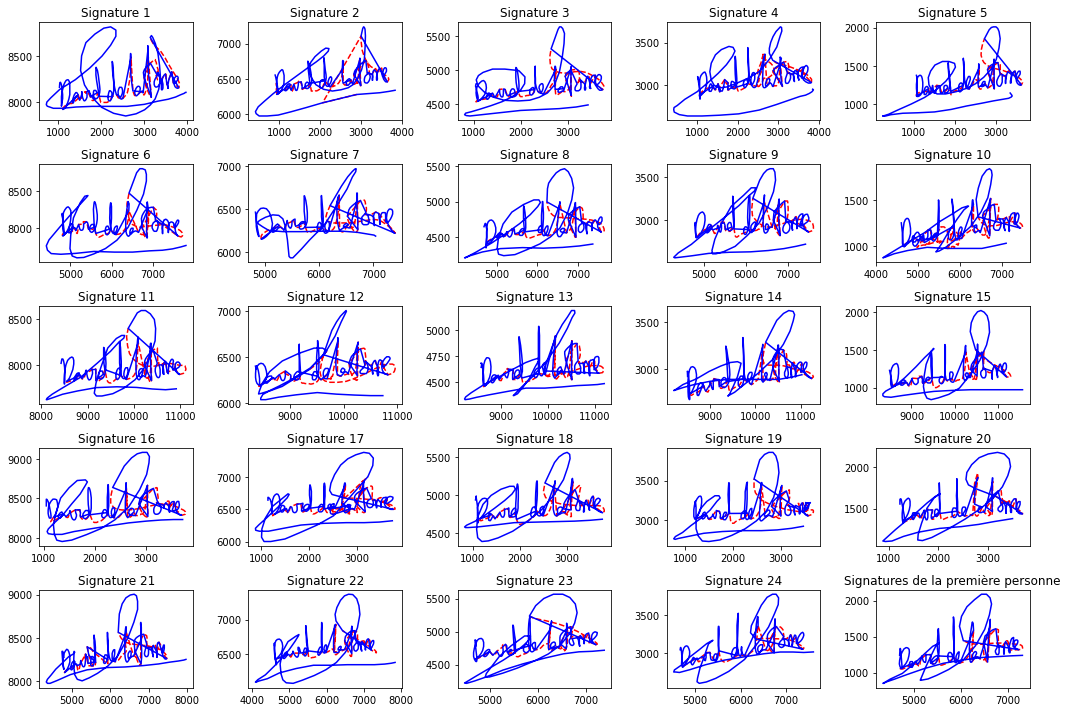

In [ ]:
# Données signatures
fig, axes = plt.subplots(5,5, figsize=(15,10))
for i,ax in enumerate(axes.flat):
  dt = pd.read_table('drive/MyDrive/Colab/Handwritten_sig/BD/2v{}.txt'.format(i), sep=' ', header=None)
  dt.columns = ['X', 'Y', 'P', 'Az', 'Al']
  dt_air = dt[dt['P'] == 0 ]
  dt_feuille = dt[dt['P'] != 0 ]
  ax.plot(dt_air['X'], dt_air['Y'], "r--")
  ax.plot(dt_feuille['X'], dt_feuille['Y'], "b")
  ax.set_title('Signature {}'.format(i+1))
plt.title('Signatures de la première personne')
fig.tight_layout()
plt.show()
  

---
## <font color='LimeGreen'> 2.   Experimental work ⛑ </font>
- A - Classification non-supervisées des personnes pour analyser l’apport de la mesure de complexité
- B - Classification non-supervisées des signatures (writer-independent)
- C - Apprentissage et généralisation



---


### <font color='PaleGreen'> A - Classification non-supervisées des personnes pour analyser l’apport de la mesure de complexité </font>

In [ ]:
# Mesure de complexité moyenne par personne sur les 25 signatures pour NG = 4
mean4 = complex_4G.mean(axis=1)
# Mesure de complexité moyenne sur les 25 signatures pour NG = 8
mean8 = complex_8G.mean(axis=1)

# Mesure de complexité moyenne sur les 25 signatures pour NG = 24
mean24 = complex_24G.mean(axis=1)

#Dataframe des moyennes
mean_complexity = pd.DataFrame({'4G': mean4,'8G':mean8,'24G':mean24})
mean_complexity.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


,4G,8G,24G
0,33.196174,29.089110,19.336863
1,29.986983,27.738042,22.572258
2,30.667706,29.347793,26.631319
3,31.983777,29.137399,25.293955
4,28.689045,26.999809,23.179699
5,30.716722,29.220561,26.713651
6,29.552929,28.779939,24.927115
7,28.392685,26.220018,19.673326
8,29.181635,28.539514,25.571022
9,31.040593,29.062635,24.102158



**Remarque :** Nous connaissons le nombre de clusters que l'on souhaite avoir ainsi les méthodes kmeans, kmedoid, méthode par modèle (avec implémentation de l'EM) semblent à première vu une bonne approche. 

In [4]:
# Clasiffication des 100 personnes en 3 catégories
# Méthode 1 : Grace au model GMM avec algo de l'EM pour des modèles de mélanges gausiennes

from sklearn import preprocessing
from sklearn.mixture import GaussianMixture

n_cluster = 3
# Reshape pour avoir matrice 100*1 pour scale
dt4 = np.array(mean_complexity['4G']).reshape(100,1)
dt8 = np.array(mean_complexity['8G']).reshape(100,1)
dt24 = np.array(mean_complexity['24G']).reshape(100,1)

# Distribution de moyenne 0 et de variance 1
scale4 = preprocessing.StandardScaler()
scale8 = preprocessing.StandardScaler()
scale24 = preprocessing.StandardScaler()

scale4.fit(dt4)
scale8.fit(dt8)
scale24.fit(dt24)

x_train = pd.DataFrame({'4G' : [scale4.transform(dt4)],'8G' : [scale8.transform(dt8)], '24G' : [scale24.transform(dt24)]})

gmm = GaussianMixture(n_components = n_cluster)

pred_4 = gmm.fit_predict(dt4)
pred_8 = gmm.fit_predict(dt8)
pred_24 = gmm.fit_predict(dt24)


NameError: ignored

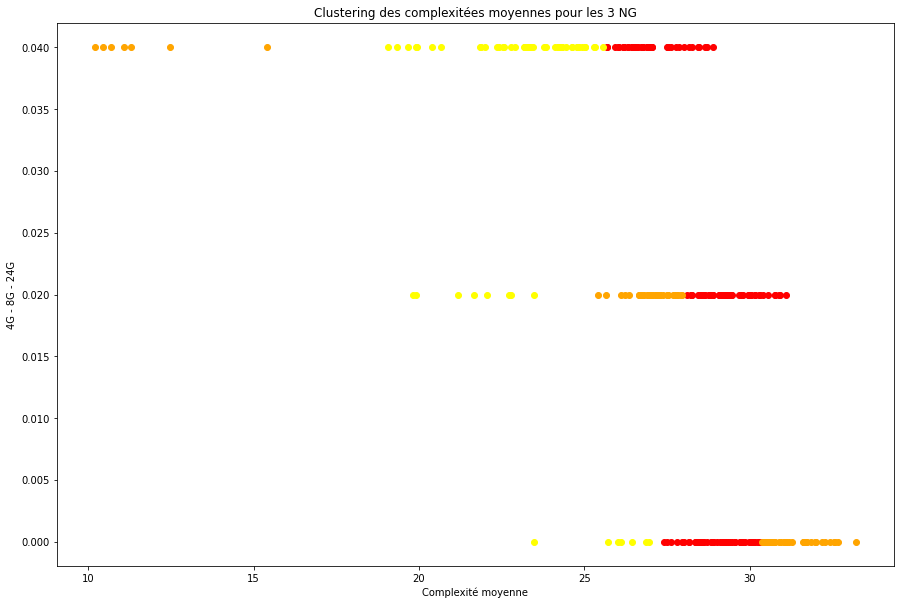

In [ ]:
# Print figure avec superpositions des 3 NG pour pouvoir comparer
fig = plt.figure(figsize=(15,10))
color =['red', 'orange', 'yellow']
for i in range(n_cluster):
  x4 = mean_complexity['4G'][pred_4==i]
  x8 = mean_complexity['8G'][pred_8==i]
  x24 = mean_complexity['24G'][pred_24==i]
  plt.scatter(x4, np.zeros_like(x4), color=color[i])
  plt.scatter(x8, np.ones(len(x8))*0.02, color=color[i])
  plt.scatter(x24, np.ones(len(x24))*0.04, color=color[i])
plt.title('Clustering des complexitées moyennes pour les 3 NG')
plt.xlabel('Complexité moyenne')
plt.ylabel('4G - 8G - 24G')
plt.show()

In [ ]:
# Critère pour voir performance de cette méthode
tot = [len(mean_complexity['4G']), len(mean_complexity['8G']), len(mean_complexity['24G'])]
# 1 - Pourcentage de personnes en chaque cluster :
tab_res = pd.DataFrame(np.array([[len(mean_complexity['4G'][pred_4==0])/tot[0],len(mean_complexity['8G'][pred_8==0])/tot[1], len(mean_complexity['24G'][pred_24==0])/tot[2]],
                                 [len(mean_complexity['4G'][pred_4==1])/tot[0],len(mean_complexity['8G'][pred_8==1])/tot[1], len(mean_complexity['24G'][pred_24==1])/tot[2]],
                                 [len(mean_complexity['4G'][pred_4==2])/tot[0],len(mean_complexity['8G'][pred_8==2])/tot[1], len(mean_complexity['24G'][pred_24==2])/tot[2]]]),
                       columns = ['4G','8G','24G'])
tab_res.head(10)

,4G,8G,24G
0,0.19,0.35,0.45
1,0.15,0.08,0.48
2,0.66,0.57,0.07


In [ ]:
#Représentation de la classification
fig, axes = plt.subplots(3,3, figsize=(15,10))
c_faible = [list(pred_4).index(0), list(pred_8).index(0), list(pred_24).index(0)]
c_moyenne = [list(pred_4).index(1), list(pred_8).index(1), list(pred_24).index(1)]
c_forte = [list(pred_4).index(2), list(pred_8).index(2), list(pred_24).index(2)]
classe = [c_faible, c_moyenne, c_forte]
for i,ax in enumerate(axes.flat):
    dt = pd.read_table('BD/{}v0.txt'.format(classe[i]), sep=' ', header=None)
    dt.columns = ['X', 'Y', 'P', 'Az', 'Al']
    dt_air = dt[dt['P'] == 0 ]
    dt_feuille = dt[dt['P'] != 0 ]
    ax.plot(dt_air['X'], dt_air['Y'], "r--")
    ax.plot(dt_feuille['X'], dt_feuille['Y'], "b")
    ax.set_title('Signature {}'.format(i+1))
plt.title('Signatures de la première personne')
fig.tight_layout()
plt.show()

In [ ]:
# Clasiffication des 100 personnes en 3 catégories
# Méthode 2 : K-means avec K = 3


In [ ]:
# Clasiffication des 100 personnes en 3 catégories
# Méthode suplémentaire pour vérifier si 3 clusters suffisent : DBSCAN

from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Configuration options
num_samples_total = 1000
cluster_centers = [(3,3), (7,7)]
num_classes = len(cluster_centers)
epsilon = 1.0
min_samples = 13

# Generate data
X, y = make_blobs(n_samples = num_samples_total, centers = cluster_centers, n_features = num_classes, center_box=(0, 1), cluster_std = 0.5)

np.save('./clusters.npy', X)
X = np.load('./clusters.npy')

# Compute DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X)
labels = db.labels_

no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

# Generate scatter plot for training data
colors = list(map(lambda x: '#3b4cc0' if x == 1 else '#b40426', labels))
plt.scatter(X[:,0], X[:,1], c=colors, marker="o", picker=True)
plt.title('Two clusters with data')
plt.xlabel('Axis X[0]')
plt.ylabel('Axis X[1]')
plt.show()